In [1]:
# imports
import pathlib
import datetime
import random
import numpy as np
import json
import torch
import torch.nn as nn

from tqdm import tqdm
from IPython.display import clear_output
from model import NCA_model
from utils import Utils

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
def show_image(img):
    #print ('img.shape: ', img.shape)
    img_rgb = Utils.to_rgb(img).squeeze().permute(1, 2, 0)
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()

def show_batch(batch_size, before, after, dpi=256):
    fig = plt.figure(figsize=(batch_size, 2), dpi=dpi)
    axarr = fig.subplots(nrows=2, ncols=batch_size)
    gspec = gridspec.GridSpec(2, batch_size)
    gspec.update(wspace=0.1, hspace=0) # set the spacing between axes.
    plt.clf()
    
    for i in range(batch_size):
        img_i = before[i]
        img_i = img_i[:4].unsqueeze(0)
        img_rgb = Utils.to_rgb(img_i).squeeze().permute(1, 2, 0)
        axarr[0, i] = plt.subplot(gspec[i])
        axarr[0, i].set_xticks([])
        axarr[0, i].set_yticks([])
        axarr[0, i].imshow(img_rgb, aspect='equal')
        axarr[0, i].set_title(str(i), fontsize=8)
        
    for i in range(batch_size):
        img_i = after[i]
        img_i = img_i[:4].unsqueeze(0)
        img_rgb = Utils.to_rgb(img_i).squeeze().permute(1, 2, 0)
        axarr[1, i] = plt.subplot(gspec[i+batch_size])
        axarr[1, i].set_xticks([])
        axarr[1, i].set_yticks([])
        axarr[1, i].imshow(img_rgb, aspect='equal')
        
    plt.show()

In [3]:
# code block used for experiments

seed = Utils.make_seed(16, 16)
pad = 16
seed = nn.functional.pad(seed, (pad, pad, pad, pad), 'constant', 0)
pool = seed.clone().repeat(8, 1, 1, 1)

#show_batch(8, pool, pool)

In [4]:
# code block used for experiments

import sys
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(profile="full")

x = torch.rand(2, 3, 3, 3)
#print (x)

z = torch.zeros(1, 3, 3, 1)
x[-1:] *= z
#print (x)

In [5]:
# training parameters
img = 'imgs\\rainbow.png'
name = 'rainbow'
viz_train = True

size = 32
pad = 24
n_channels = 16
hid_channels = 128
fire_rate = 0.5

n_train_iter = 5000
batch_size = 5
pool_size = 32
n_damage = 2
iter_start_damage = 1000

checkpoint_freq = 1000
eval_freq = 500
eval_iter = 300

log_dir = 'logs'
model_dir = 'models'
checkpoint_dir = 'checkpoints'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print ('cuda available? ', torch.cuda.is_available())
print ('device: ', device)

cuda available?  True
device:  cuda


In [6]:
# misc
full_size = size + (2 * pad)
#device_n = torch.device(device)

# create log
log_path = pathlib.Path(log_dir)
log_path.mkdir(parents=True, exist_ok=True)

# target image
loaded_img = Utils.load_image(img, size)
target_img_ = nn.functional.pad(loaded_img, (pad, pad, pad, pad), 'constant', 0)
target_img = target_img_.to(device)
target_img = target_img.repeat(batch_size, 1, 1, 1)

# show image
print ('target image: ')
show_image(loaded_img)

img.shape:  (32, 32)


ValueError: operands could not be broadcast together with shapes (32,3) (32,29) (32,3) 

In [ ]:
# save model
def save_model(_dir, _model, _name = None):
    model_path = pathlib.Path(_dir)
    model_path.mkdir(parents=True, exist_ok=True)
    if _name == None:
        ts = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').replace('.', '-')
        _name = 'model_' + ts
    torch.save(_model.state_dict(), _dir + '\\' + _name + '.pt')
    
    # save model parameters
    dict = {
        "img": img,
        "batch_size": batch_size,
        "device": device,
        "eval_freq": eval_freq,
        "eval_iter": eval_iter,
        "n_train_iter": n_train_iter,
        "n_channels": n_channels,
        "log_dir": log_dir,
        "pad": pad,
        "pool_size": pool_size,
        "size": size,
        "model_dir": _dir,
        "name": _name,
        "damage": n_damage
    }
    json_object = json.dumps(dict, indent=4)
    with open(_dir + '\\' + _name + '_params.json', 'w') as outfile:
        outfile.write(json_object)
        print ('model saved!')

In [ ]:
# model and optimizer
load_checkpoint = False
checkpoint = 'cowboy.pt'

model = NCA_model(_n_channels=n_channels, _hid_channels=hid_channels, _fire_rate=fire_rate, _device=device)
if load_checkpoint:
    model.load_state_dict(torch.load(checkpoint_dir + '\\' + checkpoint, map_location=device))
    print ('loaded checkpoint!')
    
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

train/loss:  2 / 0.022737780585885048


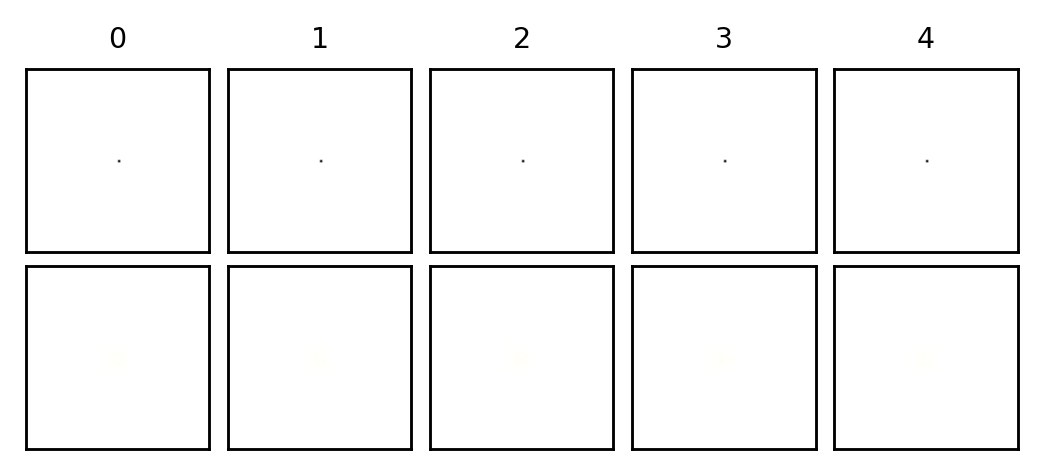

  0%|          | 3/5000 [00:03<1:30:47,  1.09s/it]

In [ ]:
# training loop begin

# pool init
seed = Utils.make_seed(size, n_channels).to(device)
seed = nn.functional.pad(seed, (pad, pad, pad, pad), 'constant', 0)
pool = seed.clone().repeat(pool_size, 1, 1, 1)
cp_count = 0

def loss_f(x):
    return ((target_img - x[:, :4, ...]) ** 2).mean(dim=[1, 2, 3])

# training loop
for it in tqdm(range(n_train_iter)):
    batch_ixs = np.random.choice(
        pool_size, batch_size, replace=False
    ).tolist()
    
    # get training batch and set first in batch as seed
    x = pool[batch_ixs]
    
    # sort batch by loss, replace the highest-loss sample with the seed.
    loss_rank = loss_f(x).detach().cpu().numpy().argsort()[::-1]
    x = x[loss_rank.copy()]
    x[0] = seed.clone()
    
    # damage examples in batch
    if n_damage > 0 and it > iter_start_damage:
        radius = random.uniform(size*0.1, size*0.3)
        u = random.uniform(0, 1) * size + pad
        v = random.uniform(0, 1) * size + pad
        mask = Utils.create_circle_mask(full_size, radius, [u, v])
        x[-n_damage:] *= torch.tensor(mask).to(device)
        
    # visualize batch
    if viz_train:
        before = x.detach().cpu()
    
    # forward pass
    for i in range(np.random.randint(64, 96)):
        x = model(x)
        
    loss_batch = ((target_img - x[:, :4, ...]) ** 2).mean(dim=[1, 2, 3])
    loss = loss_batch.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print ('train/loss: ', it, '/', loss.item())
    
    # visualize batch
    if viz_train:
        after = x.detach().cpu()
        show_batch(batch_size, before, after)
    
    # find best in batch
    argmax_batch = loss_batch.argmax().item()
    argmax_pool = batch_ixs[argmax_batch]
    remaining_batch = [i for i in range(batch_size) if i != argmax_batch]
    remaining_pool = [i for i in batch_ixs if i != argmax_pool]
    
    # replace most loss example with seed
    if it <= iter_start_damage:
        pool[argmax_pool] = seed.clone()
        pool[remaining_pool] = x[remaining_batch].detach()
    else:
        pool[batch_ixs] = x.detach()
    
    # clear output after 100 iterations
    if it % 100 == 0 and it != 0:
        clear_output(wait=True)
    
    # check for create checkpoint
    if it % checkpoint_freq == 0 and it > 0:
        save_model(checkpoint_dir, model, name + '_cp' + str(cp_count))
        cp_count += 1

# save final model
save_model(model_dir, model, name)

In [ ]:
# click here to watch batch viz





